In [ ]:
# Here, I implement the power rate diffusion model from
# Palmer, Huk and Shadlen '05. 

In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import factorial as fact

In [2]:
# List subjects to fit
subs = ['Sub01', 'Sub02', 'Sub04', 'Sub05', 'Sub06', 'Sub08', 'Sub10', 'Sub11', 'Sub13']
nSub = len(subs)

# Initialize arrays to hold PC, mean and SD of RT, and # trials 
# for each coherence-distanct combination
# These values are obtained from the .csv files
pCs = np.zeros((20, nSub))
mRTs = np.zeros((20, nSub))
sdRTs = np.zeros((20, nSub))
Ns = np.zeros((20, nSub))

# Initialise a variable to hold # correct trials
# This will be computed from Ns and pCs
Rs = np.zeros((20, nSub))

In [3]:
# Extract behavioral data (PC, mean and SD of RT, # trials) from csv files
for si in range(nSub):
    csvFile = '../Data/Behavior/' + subs[si] + '_behavData.csv'
    behavData = pd.read_csv(csvFile, header=None)
    
    # Split the file in PC, mean RT and SD RT
    # Flatten each subject's values for ease of programming
    pCs[:,si] = np.array(behavData[0:4]).flatten()
    mRTs[:,si] = np.array(behavData[4:8]).flatten()
    sdRTs[:,si] = np.array(behavData[8:12]).flatten()
    Ns[:,si] = np.array(behavData[12:]).flatten()
    Rs[:,si] = np.round(Ns[:,si] * pCs[:,si])

In [4]:
# Parameters to fit:
# A: Boundary
# x: Stimulus strength
# k: Proportionality constant 
# b: power factor (Stim. str. = (k*x)^b)
# tR: Residual time

# Equations to fit for each stimulus strength:
# pC = 1 / (1+exp(-2*A*(k*abs(x))^b))
# mRT = A / ((k*x)^b) * tanh(A*(k*x)^b) + tR

# We can get approximate values for A, k and tR from Palmer et. al. '05
# Ranges of parameters to start with:
# A: 0.5 - 1
# k: 5 - 40
# tR: 0.25 - 0.5 (in seconds)
# x: 0 - 1

# To identify best fit, calculate the likelihood of predicted pC and mRT and find the maximum likelihood.

# Likelihood of pC follows a binomial distribution
# Lp = n! / (r!(n-r)! * pC(x)^r * (1-pC(x))^(n-r), where
# n = # trials, r = # required correct

# Likelihood of mRT follows a Gaussian distribution
# Lrt = 1 / (SDrt * (sqrt(2*pi))) * e^-((mRT(x) - oRT(x)) / SDrt)^2 * 1/2, where
# oRT = observed mRT, mRT = predicted mRT, SDrt = SD of predicted mRT
# VARrt = VARtd + VARtr, where
# VARtd = variance in decision time, VARtr = variance in residual time. Thus,
# VARrt = (A * tanh(A*(k*x)^b) - A*(k*x)^b * sech(A*(k*x)^b)) / ((k*x)^b)^3 + (0.1 * tR)^2

# Final fit measure is the log likelihood, which is the sum of the likelihoods of accuracy and mean RT, 
# over all combinations of coherence and distance
# Lprt = sigma(x)(ln(Lp(s)) + ln(Lrt(x)))

# The first pass of the model will be to estimate values of x without any assumptions about stimulus relationtips.
# The stopping point will be the point of least error.

In [5]:
# Initialize A, k and tR parameters
A, dA = np.linspace(0.5, 5, 10, retstep=True)
# k, dk = np.linspace(0.3, 2, 20, retstep=True)
k, dk = np.linspace(1, 10, 10, retstep=True)
b, db = np.linspace(0.2, 5, 10, retstep=True)
tR, dtR = np.linspace(0.2, 1.5, 10, retstep=True)

As, ks, bs, tRs = np.meshgrid(A, k, b, tR)
As = As.flatten()
ks = ks.flatten()
bs = ks.flatten()
tRs = tRs.flatten()

# This is the overall number of permutations of A, k and tR being performed
nPar = len(As)

# Initialize stimulus strength parameter
# x, dx = np.linspace(0.1, 10, 200, retstep=True)
x, dx = np.linspace(0.01, 1, 20, retstep=True)

# Initialize arrays that hold predicted accuracies and RTs
epc = np.ones((nPar, len(x), 20, 9)) * -9
ert = np.ones((nPar, len(x), 20, 9)) * -9
sdrt = np.ones((nPar, len(x), 20, 9)) * -9

## Initialize the array that holds the
# individual likelihood values
lpc = np.zeros((nPar, len(x), 20, 9))
lrt = np.zeros((nPar, len(x), 20, 9))
# final likelihood values
ll = np.ones((nPar, len(x), 9)) * -9

In [6]:
# From the set of parameters, calculate the (expected) predicted PC and RT
# and then find the likelihood that these estimates match the observed PC and RT
for si in range(nSub):
    for pi in xrange(nPar):
        for cdi in range(20):
            # Calculate expected accuracy for each coherence-distance combination
            epc[pi,:,cdi,si] = 1 / (1 + np.exp(-2 * As[pi] * (ks[pi] * abs(x)) ** bs[pi]))
            # And the likelihood of this accuracy
            lpc[pi,:,cdi,si] = fact(Ns[cdi,si]) / (fact(Rs[cdi,si]) * fact(Ns[cdi,si]-Rs[cdi,si])) * \
                                (epc[pi,:,cdi,si] ** Rs[cdi,si]) * \
                                ((1 - epc[pi,:,cdi,si]) ** (Ns[cdi,si] - Rs[cdi,si]))
            
            # Calculate expected mean RT for each coherence-distance combination
            ert[pi,:,cdi,si] = As[pi] / ((ks[pi] * x) ** bs[pi]) * \
                                np.tanh(As[pi] * (ks[pi] * x) ** bs[pi]) + tRs[pi] 
            # And standard error of the mean
            sdrt[pi,:,cdi,si] = np.sqrt(((As[pi] * np.tanh(As[pi] * (ks[pi] * x) ** bs[pi]) - \
                    As[pi] * (ks[pi] * x) ** bs[pi] * (1/np.cosh(np.square(As[pi] * (ks[pi] * x) ** bs[pi])))) / \
                    ((ks[pi] * x) ** bs[pi]) ** 3 + np.square(0.1 * tRs[pi])) / Ns[cdi,si])
            # And the likelihood of observing that RT
            lrt[pi,:,cdi,si] = 1 / (sdrt[pi,:,cdi,si] * np.sqrt(2 * np.pi)) * \
                                np.e ** (-1/2 * np.square((ert[pi,:,cdi,si] - mRTs[cdi,si]) / sdrt[pi,:,cdi,si]))

In [7]:
# See if there are any weird PC, mRT or sdrt values generated in the parameter space
print(np.sum(np.isinf(epc)))
print(np.sum(np.isnan(epc)))
print(np.sum(epc < 0))
print(np.sum(np.isinf(ert)))
print(np.sum(np.isnan(ert)))
print(np.sum(ert < 0))
print(np.sum(np.isinf(sdrt)))
print(np.sum(np.isnan(sdrt)))
print(np.sum(sdrt < 0))

0
0
0
0
0
0
0
2129400
0


In [8]:
# Find indices where sdrt is NaN (or, variance is negative)
tmpId = np.where(np.isnan(sdrt))[0]
sdIdx = np.unravel_index(tmpId, sdrt.shape)

# Find the fraction of trials that have NaN sdrt
print(len(sdIdx[0])/np.double(np.prod(sdrt.shape)))

# First see if it's any specific subjects that show this effect - no
print(np.unique(sdIdx[3]))
for i in range(nSub):
    print(np.sum(sdIdx[3] == i))

# Any specific CD combinations - no
print(np.unique(sdIdx[2]))
for i in range(20):
    print(np.sum(sdIdx[2] == i))

# Any specific x's - smaller ones
print(np.unique(sdIdx[1]))
for i in range(len(x)):
    print(np.sum(sdIdx[1] == i))

# Any specific A-k-tR combinations 
print(np.unique(sdIdx[0]))

0.05915
[0 1 2 3 4 5 6 7 8]
238320
239760
237600
236520
236160
235620
235260
235080
235080
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
128700
128520
111420
106920
105120
103680
102600
100440
100440
100440
100440
112680
113940
107460
104220
102780
100800
100440
99180
99180
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 16 17 18 19]
576000
54000
118800
43200
54000
238320
217080
28800
97200
0
50400
230400
43200
61200
28800
0
64800
133200
10800
79200
[0 1 2]


In [9]:
bestXcd = np.ones((nPar, 20, nSub)) * -9
totLL = np.zeros((nPar, nSub))
for si in range(nSub):
    for pi in range(nPar):
        # At each A-k-tR combination, find the index of x value 
        # that maximizes likelihood for each CD combination
        bestXcd[pi,:,si] = np.argmax(lpc[pi,:,:,si] * lrt[pi,:,:,si],0)
        for cdi in range(20):
            # Sum over all CDs to obtain overall likelihood for the 
            # give A-k-tR combination
            totLL[pi,si] += np.log(lpc[pi,bestXcd[pi,cdi,si],cdi,si]) + \
                                np.log(lrt[pi,bestXcd[pi,cdi,si],cdi,si])

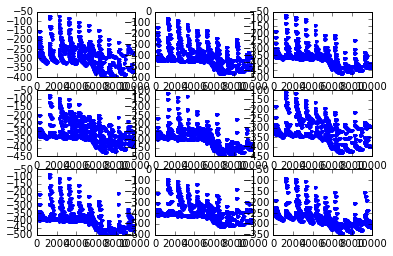

In [10]:
for si in range(nSub):
    plt.subplot(3,3,si+1)
    plt.plot(totLL[:,si],'.')
    #plt.ylim(-200, 0)

In [24]:
# Find the parameters for which likelihood is maximum
# There are some NaN values in the likelihood matrix so exclude those
maxParId = np.zeros(nSub)

# Record the values of best fit x for each CD combination
bestx = np.zeros((20, nSub))

for si in range(nSub):
    tmpIds = np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0]
    if len(tmpIds) == 1:
        maxParId[si] = tmpIds
    else:
        maxParId[si] = tmpIds[0]
    bestx[:,si] = bestXcd[maxParId[si],:,si]
    # print(np.where(totLL[:,si] == np.nanmax(totLL[:,si]))[0])

In [25]:
for si in range(nSub):
    print(totLL[maxParId[si],si])

-72.7330571871
-60.9450991484
-72.7181818002
-79.7636051102
-117.786518434
-109.092957308
-83.6288909549
-92.3865942255
-89.1599039574


In [26]:
# Print the parameter values predicting maximum likelihoods
# for the different coherence-distance combinations
for si in range(nSub):
    print(round(As[maxParId[si]],ndigits=3), round(ks[maxParId[si]],ndigits=3), \
          round(bs[maxParId[si]],ndigits=3), round(tRs[maxParId[si]],ndigits=3))
    print(np.reshape(bestXcd[maxParId[si],:,si],(4,5)))

(1.5, 2.0, 2.0, 0.2)
[[  2.   2.   3.   2.   2.]
 [  3.   3.   5.   5.   6.]
 [  2.   6.   7.   7.   7.]
 [  2.   9.  13.  13.  13.]]
(1.5, 2.0, 2.0, 0.2)
[[  3.   2.   3.   3.   3.]
 [  2.   4.   8.   8.   8.]
 [  3.   6.   9.   9.   9.]
 [  3.   4.  13.  13.  14.]]
(1.5, 2.0, 2.0, 0.2)
[[  3.   4.   3.   2.   2.]
 [  3.   3.   8.   8.   8.]
 [  2.   5.  10.  11.  11.]
 [  2.   4.  13.  15.  15.]]
(1.5, 2.0, 2.0, 0.2)
[[  2.   2.   2.   2.   3.]
 [  2.   2.   4.   4.   4.]
 [  2.   4.  11.  11.  12.]
 [  3.   8.  13.  15.  15.]]
(1.5, 2.0, 2.0, 0.2)
[[  2.   2.   2.   2.   2.]
 [  2.   3.   4.  10.   4.]
 [  2.   4.  12.  12.  13.]
 [  2.  11.  15.  16.  17.]]
(1.5, 2.0, 2.0, 0.2)
[[  3.   3.   2.   2.   2.]
 [  3.   3.   4.   4.   4.]
 [  2.   3.   9.  10.  10.]
 [  2.   3.  12.  13.  13.]]
(1.5, 2.0, 2.0, 0.2)
[[  2.   2.   2.   2.   2.]
 [  2.   3.   9.  10.  10.]
 [  2.   4.  12.  12.  12.]
 [  2.   4.  13.  15.  16.]]
(1.5, 2.0, 2.0, 0.2)
[[  2.   2.   2.   2.   2.]
 [  2.   3.  

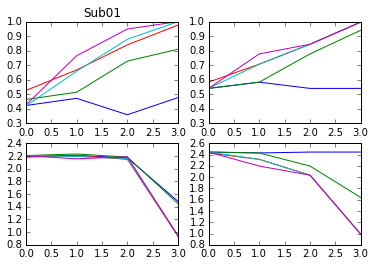

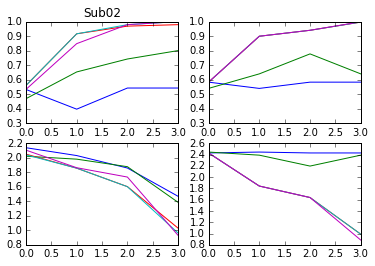

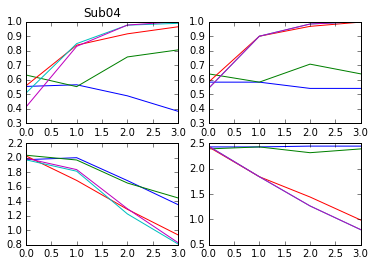

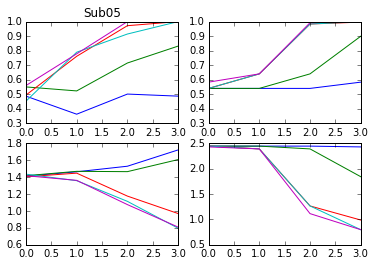

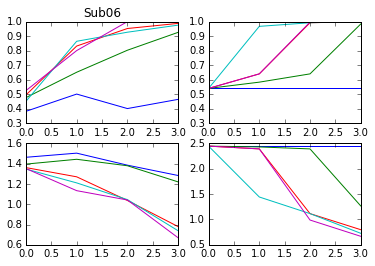

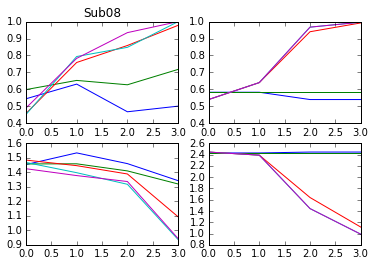

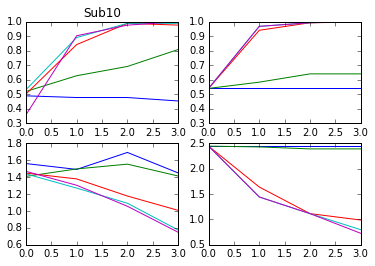

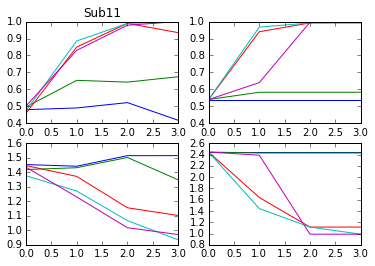

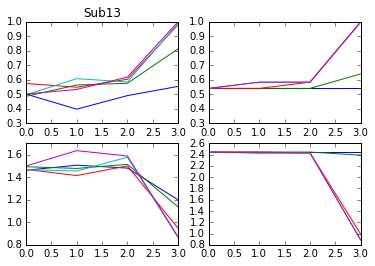

In [27]:
for si in range(nSub):
    temp = []
    plt.figure()
    plt.subplot(221)
    plt.title(subs[si])
    plt.plot(np.reshape(pCs[...,si],(4,5)))
    ymin, ymax = plt.ylim()
    plt.subplot(222)
    for cdi in range(20):
        temp.append(epc[maxParId[si], bestx[cdi,si], cdi, si])
    plt.plot(np.reshape(temp,(4,5)))
    plt.ylim((ymin,ymax))

    temp = []
    plt.subplot(223)
    plt.plot(np.reshape(mRTs[...,si],(4,5)))
    ymin, ymax = plt.ylim()
    plt.subplot(224)
    for cdi in range(20):
        temp.append(ert[maxParId[si], bestx[cdi,si], cdi, si])
    plt.plot(np.reshape(temp,(4,5)))